# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [ ]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.20 which is incompatible.


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [ ]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [ ]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [ ]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [ ]:
# env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
# states = env_info.vector_observations                  # get the current state (for each agent)
# scores = np.zeros(num_agents)                          # initialize the score (for each agent)
# while True:
#     actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#     actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#     env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#     next_states = env_info.vector_observations         # get next state (for each agent)
#     rewards = env_info.rewards                         # get reward (for each agent)
#     dones = env_info.local_done                        # see if episode finished
#     scores += env_info.rewards                         # update the score (for each agent)
#     states = next_states                               # roll over states to next time step
#     if np.any(dones):                                  # exit loop if episode finished
#         break
# print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

## Training agents

In [6]:
import gym
import random
import torch
import numpy as np
from collections import deque
from workspace_utils import active_session
import matplotlib.pyplot as plt
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from ddpg_agent import Agent

SEED = 7

def seed_all(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

seed_all(SEED)
agent = Agent(state_size=state_size, action_size=action_size, random_seed=SEED)
agent.actor_local.load_state_dict(torch.load('checkpoint_actor_partial.pth'))
agent.actor_target.load_state_dict(torch.load('checkpoint_actor_partial.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic_partial.pth'))
agent.critic_target.load_state_dict(torch.load('checkpoint_critic_partial.pth'))

Episode 78	Average Score: 30.03
Solved environment in 78 episodes
Episode 83	Average Score: 30.25
Score improved from 30.136340789814913 to 30.249155950384687
Episode 86	Average Score: 30.43
Score improved from 30.326587557442046 to 30.43488304065757
Episode 87	Average Score: 30.54
Score improved from 30.43488304065757 to 30.54045908748247
Episode 100	Average Score: 30.88
Episode 101	Average Score: 30.97

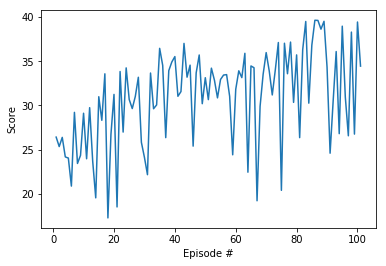

In [7]:
def ddpg(n_episodes=1000, max_t=1000, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    best_score = float("-inf")
    solved = False
    for i_episode in range(1, n_episodes+1):
        agent.reset()
        env_info = env.reset(train_mode=True)[brain_name] 
        states = env_info.vector_observations
        score = 0
        for t in range(max_t):
            actions = agent.act(states, add_noise=False)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            agent.step(states, actions, rewards, next_states, dones, update_every=20, num_updates=10)
            states = next_states
            score += np.mean(rewards)
            if np.any(dones):
                break 
        scores_deque.append(score)
        scores.append(score)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        current_score = np.mean(scores_deque)
        if current_score > best_score:
            if current_score >= 30:
                if not solved:
                    print('\nSolved environment in {} episodes'.format(i_episode))
                    solved = True
                elif current_score > best_score + 0.1:
                    print('\nScore improved from {} to {}'.format(best_score, current_score))
            best_score = current_score    
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_continue.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_continue.pth')
            if best_score >= 30 and i_episode > 100:
                break
        
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            
    return scores

with active_session():
    scores = ddpg(1000)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Training single Agent

In [ ]:
def ddpg(n_episodes=1000, max_t=1000, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    best_score = float("-inf")
    solved = False
    for i_episode in range(1, n_episodes+1):
        agent.reset()
        env_info = env.reset(train_mode=True)[brain_name] 
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done, update_every=1, num_updates=1)
            state = next_state
            score += reward
            if done:
                break 
        scores_deque.append(score)
        scores.append(score)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        current_score = np.mean(scores_deque)
        if current_score > best_score:
            if current_score >= 30:
                if not solved:
                    print('\nSolved environment in {} episodes'.format(i_episode))
                    solved = True
                elif current_score > best_score + 0.1:
                    print('\nScore improved from {} to {}'.format(best_score, current_score))
            best_score = current_score    
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            
    return scores

with active_session():
    scores = ddpg(6000)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 